In [1]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
import numpy

Using TensorFlow backend.


In [2]:
# evaluate a single mlp model
def evaluate_model(trainX, trainY, testX, testY):
    # encode targets
    trainY_enc = to_categorical(trainY)
    testY_enc = to_categorical(testY)
    # define model
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                 metrics=['accuracy'])
    # fit model
    model.fit(trainX, trainY_enc, epochs=50, verbose=0)
    # evaluate the model
    _, test_acc = model.evaluate(testX, testY_enc, verbose=0)
    return model, test_acc

In [3]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)
    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)
    # argmax across classes
    result = argmax(summed, axis=1)
    return result

In [4]:
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testY):
    # select a subset of members
    subset = members[:n_members]
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate accuracy
    return accuracy_score(testY, yhat)

In [5]:
# generate 2d classification dataset
dataX, dataY = make_blobs(n_samples=55000, centers=3, n_features=2,
                         cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
Y, newY = dataY[:5000], dataY[5000:]

In [6]:
# multiple train-test splits
n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):
    # select indexes
    ix = [i for i in range(len(X))]
    train_ix = resample(ix, replace=True, n_samples=4500)
    test_ix = [x for x in ix if x not in train_ix]
    # select data
    trainX, trainY = X[train_ix], Y[train_ix]
    testX, testY = X[test_ix], Y[test_ix]
    # evaluate model
    model, test_acc = evaluate_model(trainX, trainY, testX, testY)
    print('> %.3f' % test_acc)
    scores.append(test_acc)
    members.append(model)

W1230 20:14:58.558753  8456 deprecation_wrapper.py:119] From C:\Users\Lenovo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1230 20:14:58.578700  8456 deprecation_wrapper.py:119] From C:\Users\Lenovo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:529: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1230 20:14:58.581691  8456 deprecation_wrapper.py:119] From C:\Users\Lenovo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4420: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1230 20:14:58.614603  8456 deprecation_wrapper.py:119] From C:\Users\Lenovo\Anaconda3\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1230 20:14:58.642529  8456 deprecation_wrapper.py:119] From C:\Users\Lenovo

> 0.818
> 0.829
> 0.831
> 0.811
> 0.814
> 0.829
> 0.834
> 0.821
> 0.818
> 0.840


In [7]:
mean(scores)

0.8244593200170213

In [8]:
std(scores)

0.008867366941067727

In [9]:
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
    ensemble_score = evaluate_n_members(members, i, newX, newY)
    newY_enc = to_categorical(newY)
    _, single_score = members[i-1].evaluate(newX, newY_enc, verbose=0)
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)

> 1: single=0.819, ensemble=0.819
> 2: single=0.820, ensemble=0.820
> 3: single=0.818, ensemble=0.820
> 4: single=0.820, ensemble=0.820
> 5: single=0.820, ensemble=0.820
> 6: single=0.820, ensemble=0.820
> 7: single=0.820, ensemble=0.820
> 8: single=0.820, ensemble=0.820
> 9: single=0.820, ensemble=0.820
> 10: single=0.820, ensemble=0.820


In [10]:
mean(single_scores)

0.819558

In [11]:
std(single_scores)

0.0008148840408303435

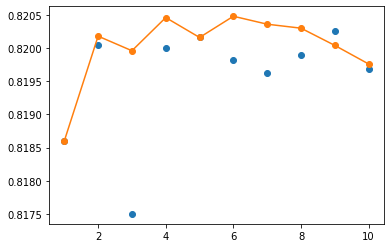

In [12]:
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()